
# Roast Coffee Bean Classifier

Welcome to the Coffee Bean Roast Classifier project! This notebook aims to classify different types of coffee bean roasts using a Convolutional Neural Network (CNN) built with TensorFlow and Keras. We will walk through the entire process of setting up the environment, loading the dataset, preprocessing the images, building and training the CNN model, and finally evaluating its performance.

## Introduction

Coffee beans are typically classified into different roast levels, such as Light, Medium, Dark, and Green. Each roast level has distinct characteristics and flavors. The ability to accurately classify coffee beans based on their roast level can be useful for coffee producers, sellers, and enthusiasts.

In this project, we will use a labeled dataset of coffee bean images to train a CNN model to classify the roast level of coffee beans. The dataset consists of images of coffee beans that are categorized into four classes: Light, Medium, Dark, and Green.

## Dataset

The dataset used in this project is sourced from the following paper:

**Dataset Source:** Ontoum, S., Khemanantakul, T., Sroison, P., Triyason, T., & Watanapa, B. (2022). Coffee Roast Intelligence. *arXiv preprint arXiv:2206.01841*. [Link to the paper](https://arxiv.org/abs/2206.01841).

The dataset is organized into training and testing directories, each containing four subdirectories corresponding to the four roast classes. Additionally, there is a CSV file that provides metadata about the dataset.

The directory structure is as follows:


In this notebook, we will use the Google Colab environment to run our code and save our results directly to Google Drive.

Let's get started by setting up our environment and loading the dataset.




In [1]:
# Step 1: Set Up the Environment

# Install necessary libraries
!pip install pydot
!pip install graphviz
!pip install tensorflow

import tensorflow as tf
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model  # Correct import for TensorFlow 2.x

# Step 1.1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setting Up the Environment and Loading the Dataset

Before we begin building our model, we need to set up the environment and load the dataset. We will start by mounting Google Drive to access the dataset, then we will load and preprocess the images. Finally, we will split the data into training and validation sets.

## Data Exploration

Before diving into model building and training, it is essential to explore and understand the dataset. In this section, we will perform data exploration by visualizing the images and analyzing the dataset's distribution. This step helps us gain insights into the data and ensures that the preprocessing steps are correctly implemented.

### Visualizing a Random Batch of Images

We start by visualizing a random batch of images from the dataset. This gives us a quick overview of the types of images and the variety within each class.


The following code block will do these steps:


Found 1200 files belonging to 4 classes.


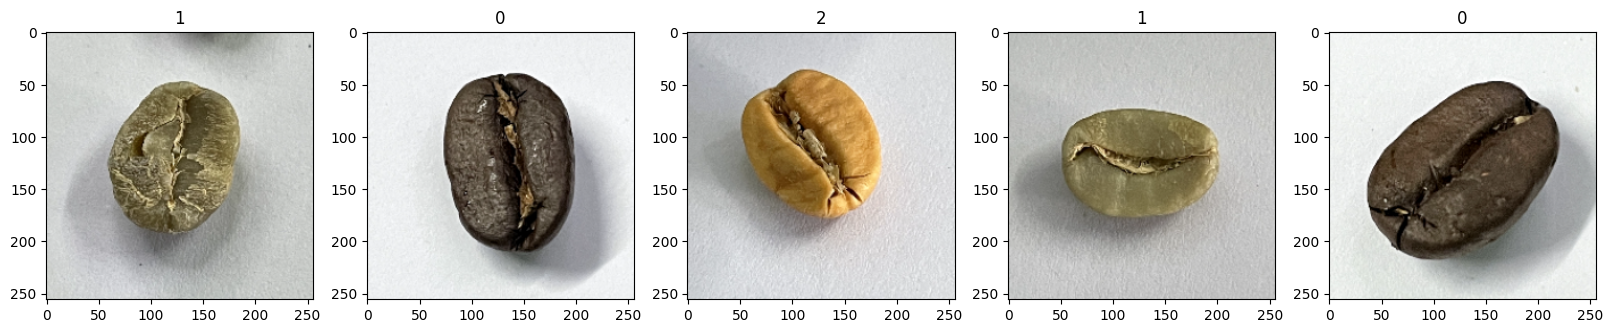

In [2]:
# Suppress warnings
import warnings,random

warnings.filterwarnings('ignore')
tf.get_logger().setLevel('INFO')
# Step 1.2: Set the data directory
data_dir = '/content/drive/My Drive/roastcoffeebeanClassifier/data'
traindata_dir = '/content/drive/My Drive/roastcoffeebeanClassifier/data/train'
image_exts = ['.png']

# Step 1.3: Load the metadata CSV file
df = pd.read_csv(os.path.join(data_dir, 'Coffee Bean.csv'))

# Create an image dataset with the given images
data = tf.keras.utils.image_dataset_from_directory(traindata_dir)

# Iterator for image iteration
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

# Visualize a random batch
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

IMG_SIZE = 50
DATADIR = '/content/drive/My Drive/roastcoffeebeanClassifier/data/train'
CATEGORIES = ['Dark', 'Green', 'Light', 'Medium']

training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_UNCHANGED)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

create_training_data()
random.shuffle(training_data)

X = []  # features
y = []  # labels

for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.asarray(y)

# Normalize data
X = X / 255.0

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)


### Dataset Analysis

Now, let's analyze the dataset to understand its distribution. We will examine the number of images in each class and visualize the distribution to ensure that the dataset is balanced.

The following code block performs dataset analysis:



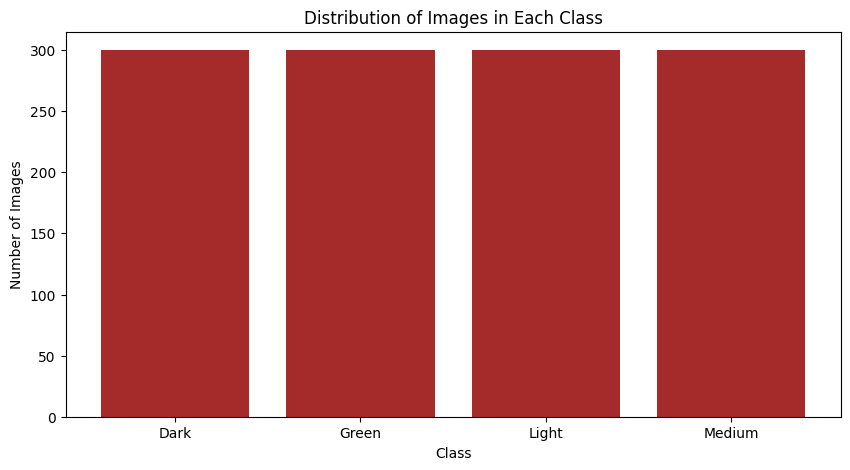

Class Distribution:
Dark: 300 images
Green: 300 images
Light: 300 images
Medium: 300 images


In [14]:
# Analyze the dataset
class_counts = {}
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    class_counts[category] = len(os.listdir(path))

# Display the distribution of classes
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='brown')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Each Class')
plt.show()

# Print class counts
print("Class Distribution:")
for category, count in class_counts.items():
    print(f"{category}: {count} images")


### Data Preprocessing

With an understanding of the dataset's distribution, we proceed to preprocess the images. This involves resizing the images to a uniform size, normalizing the pixel values, and splitting the dataset into training and validation sets. These steps are crucial to ensure that the data is in the right format for model training.

The following code block preprocesses the images:


### Data Augmentation and Model Building

To improve the model's generalization capabilities, we apply data augmentation. Data augmentation artificially increases the size of the training dataset by creating modified versions of images, which helps the model learn more robust features.

After data augmentation, we build a Convolutional Neural Network (CNN) model. CNNs are well-suited for image classification tasks due to their ability to capture spatial hierarchies in images through convolutional layers.

The following code block sets up data augmentation and builds the CNN model:


In [15]:

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# Building the model with fine-tuned L2 regularization strength
l2_strength = 0.02
model = Sequential()

# Convolutional layers with L2 regularization and batch normalization
model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:], kernel_regularizer=l2(l2_strength)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), kernel_regularizer=l2(l2_strength)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), kernel_regularizer=l2(l2_strength)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Dense layers with L2 regularization and batch normalization
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=l2(l2_strength)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dense(128, kernel_regularizer=l2(l2_strength)))
model.add(BatchNormalization())
model.add(Activation("relu"))

# Output layer
model.add(Dense(4))
model.add(Activation("softmax"))

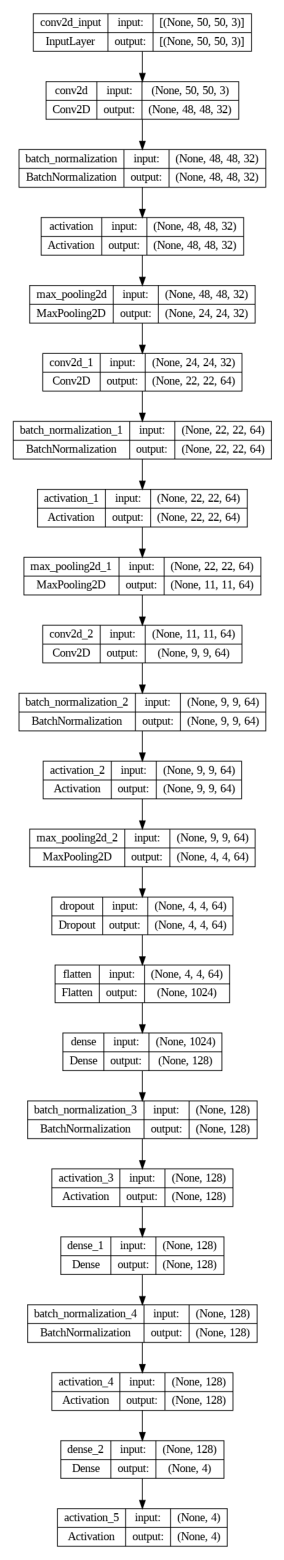

In [5]:
# Visualize the model
plot_model(model, to_file='model_visualization.png', show_shapes=True, show_layer_names=True)
img = plt.imread('model_visualization.png')
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis('off')
plt.show()


### Model Compilation and Training

With the model architecture defined, we proceed to compile and train the model. Compiling the model involves specifying the loss function, optimizer, and evaluation metrics. Training the model involves fitting it to the training data and validating it on the validation data.

To optimize the model's performance, we use the Adam optimizer with a fine-tuned learning rate. We also implement early stopping and learning rate reduction callbacks to prevent overfitting and ensure training stability.

The following code block compiles and trains the model:


In [6]:
# Compiling the model with a fine-tuned learning rate
initial_learning_rate = 0.0005
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              metrics=["accuracy"])

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=0.00001)

# Training the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=100,
                    validation_data=(X_val, y_val), callbacks=[early_stopping, lr_reduction])

# Saving the model
model_json = model.to_json()
with open("fine_tuned_model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("fine_tuned_model.h5")
print("Saved fine-tuned model to disk")

model.save('FineTunedCoffeeBeanCNN.model')

Epoch 1/100
34/34 [==============================] - 16s 141ms/step - loss: 9.6981 - accuracy: 0.6657 - val_loss: 9.8590 - val_accuracy: 0.2083 - lr: 5.0000e-04
Epoch 2/100
34/34 [==============================] - 1s 32ms/step - loss: 8.0929 - accuracy: 0.8889 - val_loss: 9.3263 - val_accuracy: 0.2083 - lr: 5.0000e-04
Epoch 3/100
34/34 [==============================] - 2s 48ms/step - loss: 6.7873 - accuracy: 0.9361 - val_loss: 8.8605 - val_accuracy: 0.2083 - lr: 5.0000e-04
Epoch 4/100
34/34 [==============================] - 2s 43ms/step - loss: 5.6510 - accuracy: 0.9481 - val_loss: 8.3425 - val_accuracy: 0.2083 - lr: 5.0000e-04
Epoch 5/100
34/34 [==============================] - 1s 32ms/step - loss: 4.7348 - accuracy: 0.9398 - val_loss: 7.6810 - val_accuracy: 0.2083 - lr: 5.0000e-04
Epoch 6/100
34/34 [==============================] - 1s 32ms/step - loss: 3.9756 - accuracy: 0.9250 - val_loss: 7.4230 - val_accuracy: 0.2083 - lr: 5.0000e-04
Epoch 7/100
34/34 [=========================

INFO:tensorflow:Assets written to: FineTunedCoffeeBeanCNN.model/assets


### Model Evaluation

After training the model, we evaluate its performance on the validation dataset. This involves plotting the training and validation accuracy and loss over the epochs to understand the model's learning process and check for overfitting.

The following code block evaluates the model:


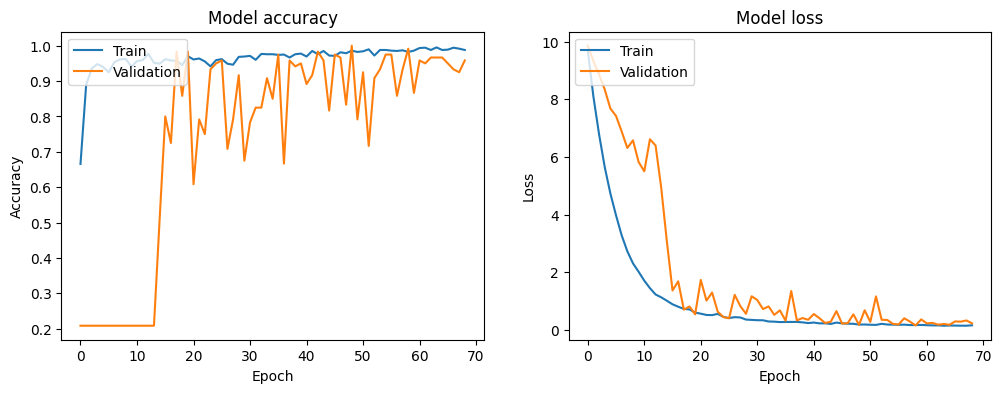

In [7]:
# Plot training & validation accuracy values for the fine-tuned model
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values for the fine-tuned model
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

4/4 [==============================] - 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

        Dark       1.00      0.97      0.99        38
       Green       1.00      1.00      1.00        25
       Light       1.00      1.00      1.00        29
      Medium       0.97      1.00      0.98        28

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



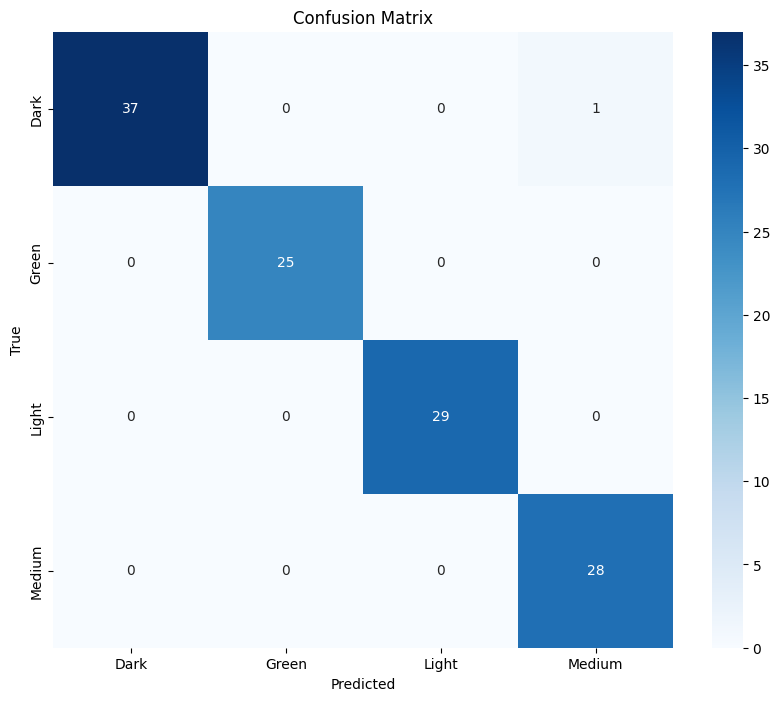

In [8]:
# Import necessary libraries for evaluation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict the validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_classes, target_names=CATEGORIES))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


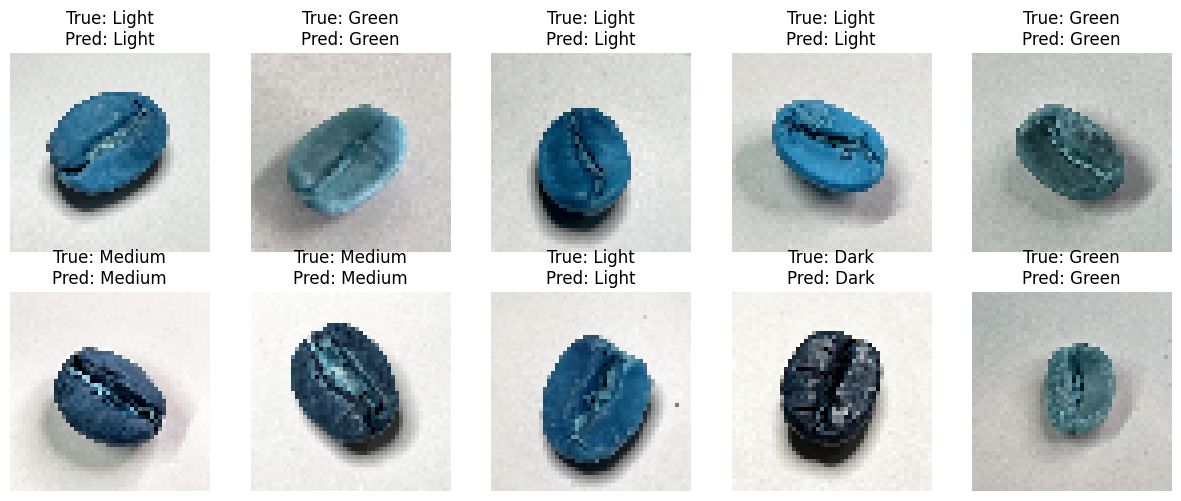

In [9]:
# Function to visualize some predictions
def visualize_predictions(images, true_labels, pred_labels, class_names, num_images=5):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}")
        plt.axis("off")
    plt.show()

# Visualize some predictions
visualize_predictions(X_val, y_val, y_pred_classes, CATEGORIES, num_images=10)


## Evaluation on Unseen Test Data:


To ensure the robustness and generalization ability of our trained model, it's important to evaluate it on unseen test data. We'll load the test data, preprocess it, and then use our model to make predictions. The performance of the model will be assessed using a classification report, confusion matrix, and visualizations of some predictions.
Loading and Preprocessing Test Data

We first load the test data from the specified directory and preprocess it similarly to the training and validation data.

13/13 [==============================] - 0s 17ms/step
Classification Report for Test Data:
              precision    recall  f1-score   support

        Dark       1.00      0.91      0.95       100
       Green       1.00      1.00      1.00       100
       Light       1.00      1.00      1.00       100
      Medium       0.92      1.00      0.96       100

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



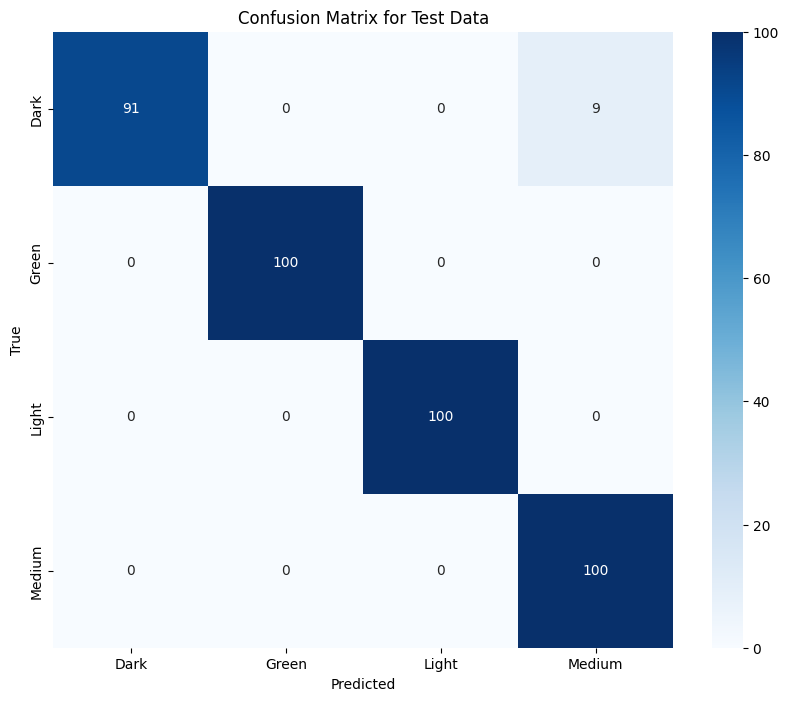

In [10]:
# Load and preprocess the test data
testdata_dir = '/content/drive/My Drive/roastcoffeebeanClassifier/data/test'
CATEGORIES = ['Dark', 'Green', 'Light', 'Medium']

test_data = []

def create_test_data():
    for category in CATEGORIES:
        path = os.path.join(testdata_dir, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_UNCHANGED)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                test_data.append([new_array, class_num])
            except Exception as e:
                pass

create_test_data()
random.shuffle(test_data)

X_test = []  # features
y_test = []  # labels

for features, label in test_data:
    X_test.append(features)
    y_test.append(label)

X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_test = np.asarray(y_test)

# Normalize test data
X_test = X_test / 255.0

# Predict the test data
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Generate the classification report for test data
print("Classification Report for Test Data:")
print(classification_report(y_test, y_test_pred_classes, target_names=CATEGORIES))

# Generate the confusion matrix for test data
conf_matrix_test = confusion_matrix(y_test, y_test_pred_classes)

# Plot the confusion matrix for test data
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title('Confusion Matrix for Test Data')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


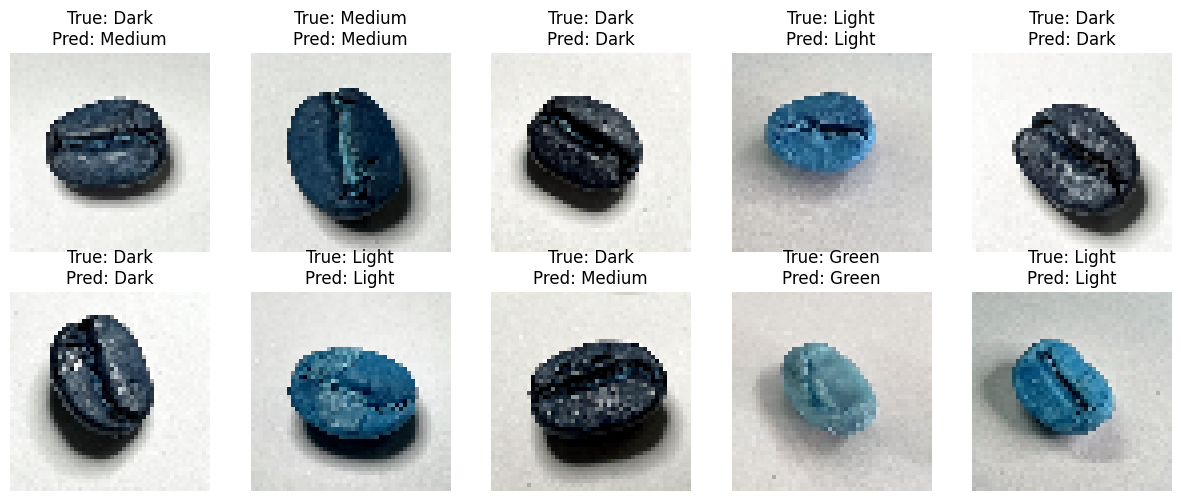

In [11]:
# Function to visualize some predictions on test data
def visualize_test_predictions(images, true_labels, pred_labels, class_names, num_images=5):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}")
        plt.axis("off")
    plt.show()

# Visualize some predictions on test data
visualize_test_predictions(X_test, y_test, y_test_pred_classes, CATEGORIES, num_images=10)